
<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)

- This code notebook implements Direct Preference Optimization (DPO) from scratch and applies it to a large language model (LLM) to enhance its ability to generate responses that align more closely with user preferences

In [1]:
# !pip install -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/requirements.txt

In [2]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.8.0
torch version: 2.5.0


&nbsp;
# 1) A brief introduction to DPO

- DPO, proposed in the paper [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290), is an alternative to reinforcement learning from human feedback (RLHF) used in finetuning large language models (LLMs)
- DPO can be used to finetune (or align) the model to generate responses that better align with user expectations and instructions

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/1.webp" width=500px>

- In instruction finetuning, we train the LLM to generate correct answers given a prompt
- However, in practice, there are multiple ways to give a correct answer, and correct answers can differ in style; for example, consider a technical and a more user-friendly response when asking an LLM to give recommendations when buying a laptop, as shown in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/2.webp" width=700px>

- RLHF and DPO are methods that can be used to teach the LLM to prefer one answer style over the other, that is, aligning better with user preferences
- The RLHF process, which requires training a separate reward model, is outlined below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/4.webp" width=600px>

- Compared to RLHF, DPO aims to simplify the process by optimizing models directly for user preferences without the need for complex reward modeling and policy optimization
- In other words, DPO focuses on directly optimizing the model's output to align with human preferences or specific objectives
- Shown below is the main idea as an overview of how DPO works

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/5.webp?123" width=600px>

- The concrete equation to implement the DPO loss is shown below; we will revisit the equation when we implement it in Python further down in this code notebook

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=600px>

- In the equation above,
  - "expected value" $\mathbb{E}$ is statistics jargon and stands for the average or mean value of the random variable (the expression inside the brackets); optimizing $-\mathbb{E}$ aligns the model better with user preferences
  - The $\pi_{\theta}$ variable is the so-called policy (a term borrowed from reinforcement learning) and represents the LLM we want to optimize; $\pi_{ref}$ is a reference LLM, which is typically the original LLM before optimization (at the beginning of the training, $\pi_{\theta}$ and $\pi_{ref}$ are typically the same)
  - $\beta$ is a hyperparameter to control the divergence between the $\pi_{\theta}$ and the reference model; increasing $\beta$ increases the impact of the difference between
$\pi_{\theta}$ and $\pi_{ref}$ in terms of their log probabilities on the overall loss function, thereby increasing the divergence between the two models
  - the logistic sigmoid function, $\sigma(\centerdot)$ transforms the log-odds of the preferred and rejected responses (the terms inside the logistic sigmoid function) into a probability score 
- To avoid bloating the code notebook with a more detailed discussion, I may write a separate standalone article with more details on these concepts in the future
- In the meantime, if you are interested in comparing RLHF and DPO, please see the section [2.2. RLHF vs Direct Preference Optimization (DPO)](https://magazine.sebastianraschka.com/i/142924793/rlhf-vs-direct-preference-optimization-dpo) in my article [Tips for LLM Pretraining and Evaluating Reward Models](https://magazine.sebastianraschka.com/p/tips-for-llm-pretraining-and-evaluating-rms)

&nbsp;
# 2) Preparing a preference dataset for DPO

- Let's begin by loading and preparing the dataset, which may already answer a lot of the questions you might have before we revisit the DPO loss equation
- Here, we work with a dataset that contains more polite and less polite responses to instruction prompts (concrete examples are shown in the next section)
- The dataset was generated via the [create-preference-data-ollama.ipynb](create-preference-data-ollama.ipynb) notebook

&nbsp;
## 2.1) Loading a preference dataset

- The dataset is a json file with 1100 entries:

In [3]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Let's take a look at two example entries:

In [4]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [5]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}




```
# This is formatted as code
```

- As we can see above, the dataset consists of 5 keys:
    - The `'instruction'` and `'input'` that are used as LLM inputs
    - The `'output'` contains the response the model was trained on via the instruction finetuning step in chapter 7
    - the `'chosen'` and `'rejected'` entries are the entries we use for DPO; here `'chosen'` is the preferred response, and `'rejected'` is the dispreferred response
- The goal is to get the model to follow the style of the chosen over the rejected responses

- Below is a utility function that formats the model input by applying the Alpaca prompt style similar to chapter 7 ([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)):

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


- Similarly, we can format the chosen and rejected responses using the Alpaca prompt style:

In [8]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [9]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


&nbsp;
## 2.2) Creating training, validation, and test splits

- Next, we divide the dataset into 3 subsets, 85% training data, 5% validation data, and 10% test data:

In [10]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [11]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


&nbsp;
## 2.3) Developing a `PreferenceDataset` class and batch processing function

- In this section, we rewrite the `InstructionDataset` class from chapter 7 ([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)) for DPO
- This means that instead of focusing on single output sequences (responses), we modify the dataset class to return pairs of responses where one is preferred ("chosen") over the other ("rejected")
- Overall, the `PreferenceDataset` is almost identical to the `InstructionDataset` used in chapter 7:

In [ ]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


- Along with an updated `PreferenceDataset` class, we also need an updated batch collation function that we use to pad the sequences in each batch to an equal length so that we can assemble them in batches
- I added comments to the code below to illustrate the process; however, it might be easiest to understand how it works by looking at the example inputs and outputs further below:

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to hold batch data
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # Determine the longest sequence to set a common padding length
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newline ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

- Before we start using the custom collate function, let's make version of it with some of its function arguments prefilled:

In [15]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # Put the data directly on a GPU if available
    mask_prompt_tokens=True,  # This is optional
    allowed_max_length=1024   # The supported context length of the model
)

Device: cuda


- Now, let's see the `customized_collate_fn` in action and apply it to some sample data from our preference dataset; for this, we take the first two entries:

In [16]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


- Next, let's instantiate an `example_dataset` and use a PyTorch `DataLoader` to create an `example_dataloader` that mimics the data loader we will use for the model training later:

In [17]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

- The dataset has the following keys:

In [18]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


- The prompts are a list of tensors, where each tensor contains the token IDs for a given example; since we selected a batch size of 2, we have two lists of token ID tensors here:

In [19]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- We don't really need the responses for training; what we need to feed to the model during training are the `"chosen"` and `"rejected"` entries
- The  `"chosen"` and `"rejected"` response entries are padded so that we can stack them as tensors; similar to the prompts, these response texts are encoded into token IDs:

In [20]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

- The token IDs above represent the model inputs, but in this format, they are hard to interpret for us humans
- So, let's implement a small utility function to convert them back into text so that we can inspect and interpret them more easily:

In [21]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

- Let's apply the `decode_tokens_from_batch` utility function to the first prompt entry in the batch:

In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


- As we can see above, the prompt was correctly formatted; let's now do the same for the `"chosen"` response:

In [23]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


- As we can see above, similar to instruction finetuning, the response that is passed to the model during training also contains the input prompt
- Also note that we included `<|endoftext|>` tokens as padding tokens, which are necessary so that we can extend the responses to a similar length to stack them as a batch
- Don't worry; the `<|endoftext|>` tokens will be ignored in the loss later so that they won't affect the training outcome
- Let's now also inspect the corresponding rejected response:

In [24]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


- In this case, as we can see above, the rejected response is a more impolite version of the chosen response (we don't want the model to generate impolite responses)
- Lastly, let's talk about the data masks: if you took a closer look at our custom collate function we implemented above, we created a `"chosen_mask"` and a `"rejected_mask"` for each dataset entry
- The masks have the same shape as the response entries, as shown below for the `"chosen"` entry:

In [25]:
print("chosen inputs:", batch["chosen"][0].shape)
print("chosen mask:  ", batch["chosen_mask"][0].shape)

chosen inputs: torch.Size([81])
chosen mask:   torch.Size([81])


- The contents of these masks are boolean (`True` and `False`) values:

In [26]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

- The `True` values denote token IDs that correspond to the actual response
- the `False` tokens correspond to token IDs that correspond to either prompt tokens (if we set `mask_prompt_tokens=True` in the `customized_collate_fn` function, which we previously did) or padding tokens
- Hence, we can use the mask as a selection mask to select only the token IDs that correspond to the response, that is, stripping all prompt and padding tokens, as we can see below:

In [27]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [28]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


- We will make use of this mask to ignore prompt and padding tokens when computing the DPO loss later

&nbsp;
## 2.4) Creating training, validation, and test set data loaders

- Above, we worked with a small example subsets from the preference dataset for illustration purposes
- Let's now create the actual training, validation, and test set data loaders
- This process is identical to creating the data loaders in the pretraining and instruction finetuning chapters and thus should be self-explanatory

In [29]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [30]:
val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's iterate through the data loader and take a look at the dataset shapes:

In [31]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

- Each row shows the shape of the `"chosen"` and `"rejected"` entries in each batch
- Since we applied padding on a batch-by-batch basis, each row has a different shape
- This is for efficiency reasons because it would be inefficient to pad all samples to the longest sample in the whole dataset

&nbsp;
# 3) Loading a finetuned LLM for DPO alignment

- LLM alignment steps, such as RLHF or DPO, assume that we already have an instruction-finetuned model
- This section contains minimal code to load the model that was instruction finetuned and saved in chapter 7 (via [../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb))
- Make sure you run the chapter 7 code first to create the instruction-finetuned model before you proceed
- The code below will copy the instruction-finetuned model into the current directory:

In [37]:
from pathlib import Path
import shutil


finetuned_model_path = Path("gpt2-medium355M-sft.pth")
if not finetuned_model_path.exists():

    # Try finding the model checkpoint locally:
    relative_path = Path("..") / "01_main-chapter-code" / finetuned_model_path
    if relative_path.exists():
        shutil.copy(relative_path, ".")

    # If this notebook is run on Google Colab, get it from a Google Drive folder
    elif "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ:
        from google.colab import drive
        drive.mount("/content/drive")
        google_drive_path = "/content/drive/My Drive/Books/LLMs-From-Scratch/ch07/colab/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
        shutil.copy(google_drive_path, ".")

    else:
        print(
            f"Could not find '{finetuned_model_path}'.\n"
            "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
        )

- Before training the loaded model with DPO, let's make sure that the finetuned model was saved and loaded correctly by trying it out on some sample data:

In [38]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [40]:
from src.utils import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
from src.model import GPTModel

torch.manual_seed(123)

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)


Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


- As we can see above, the model gives a reasonable and correct response
- As explained in chapter 7, in practice, we would clean up the response to only return the response text with the prompt and prompt style removed (similar to what you are familiar with from ChatGPT, for example):

In [41]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


- Now, we are almost ready to get to the DPO part
- As mentioned at the beginning of this notebook, DPO works with two LLMs: a policy model (the LLM that we want to optimize) and a reference model (the original model that we keep unchanged)
- Below, we rename the `model` as `policy_model` and instantiate a second instance of the model we refer to as the `reference_model`

In [42]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

policy_model.to(device)
reference_model.to(device);

&nbsp;
# 4) Coding the DPO Loss Function

- After we took care of the model loading and dataset preparation in the previous sections, we can now get to the fun part and code the DPO loss
- Note that the DPO loss code below is based on the method proposed in the [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) paper
- For reference, the core DPO equation is shown again below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=800px>

- In the equation above,
  - "expected value" $\mathbb{E}$ is statistics jargon and stands for the average or mean value of the random variable (the expression inside the brackets); optimizing $-\mathbb{E}$ aligns the model better with user preferences
  - The $\pi_{\theta}$ variable is the so-called policy (a term borrowed from reinforcement learning) and represents the LLM we want to optimize; $\pi_{ref}$ is a reference LLM, which is typically the original LLM before optimization (at the beginning of the training, $\pi_{\theta}$ and $\pi_{ref}$ are typically the same)
  - $\beta$ is a hyperparameter to control the divergence between the $\pi_{\theta}$ and the reference model; increasing $\beta$ increases the impact of the difference between
$\pi_{\theta}$ and $\pi_{ref}$ in terms of their log probabilities on the overall loss function, thereby increasing the divergence between the two models
  - the logistic sigmoid function, $\sigma(\centerdot)$ transforms the log-odds of the preferred and rejected responses (the terms inside the logistic sigmoid function) into a probability score 
- In code, we can implement the DPO loss as follows:

In [ ]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
        label_smoothing: conservativeness for DPO loss.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    # DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

- If you are familiar with logarithms, note that we have the general relationship $\log\left(\frac{a}{b}\right) = \log a - \log b$, which we applied in the code above
- Keeping this in mind, let's go through some of the steps (we will calculate the `logprobs` using a separate function later)
- Let's start with the lines

    ```python
    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    ```

- These lines above calculate the difference in log probabilities (logits) for the chosen and rejected samples for both the policy model and the reference model (this is due to $\log\left(\frac{a}{b}\right) = \log a - \log b$):

$$\log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_\theta (y_l \mid x)} \right) \quad \text{and} \quad \log \left( \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$$

- Next, the code `logits = model_logratios - reference_logratios` computes the difference between the model's log ratios and the reference model's log ratios, i.e., 

$$\beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right)$$


- Finally, `losses = -F.logsigmoid(beta * logits)`  calculates the loss using the log-sigmoid function; in the original equation, the term inside the expectation is 

$$\log \sigma \left( \beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right) \right)$$

- Above, we assumed that the log probabilities were already computed; let's now define a `compute_logprobs` function that we can use to compute these log probabilities that were passed into the `compute_dpo_loss` function above, that is, the values $\pi_\theta (y_w \mid x)$, ${\pi_\theta (y_l \mid x)}$, and so forth:

In [44]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

- Note that this function above might look a bit intimidating at first due to the `torch.gather` function, but it's pretty similar to what happens under the hood in PyTorch's `cross_entropy` function
- For example, consider the following example:

In [ ]:
# Sample data
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # Shape: (2, 3)
targets = torch.tensor([0, 2])  # Shape: (2,)


# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # Shape 2, 1
).squeeze(1)  # Shape: (2,)
manual_loss = -selected_log_probs.mean()  # Averaging over the batch


# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)

print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


- So, above, we can see that the two implementations are equivalent, but let's narrow down a bit further to the `torch.gather` mechanics
- Consider the following two tensors:

In [50]:
t = torch.tensor(
  [[1., 2.,],
   [3., 4.]]
)

m = torch.tensor(
  [[1, 1],
   [0, 1]]
)

- Above, `t` is a tensor we want to select from, and `m` is a mask to specify how we want to select
 - For instance, since `m` contains `[1, 1]` n the first row, it will select two times the value of `t` in index position `1`, which is the value 2.
 - The second row of `m`, `[0, 1]`, selects index positions 0 and 1 in the second row or `t`, which are `3.` and `4.`

In [51]:
torch.gather(input=t, dim=-1, index=m)

tensor([[2., 2.],
        [3., 4.]])

- In other words, `torch.gather` is a selection function
- When we computed the loss earlier, we used it to retrieve the log probabilities corresponding to the correct token in the 50,256-token vocabulary
- The "correct" tokens are the tokens given in the response entry

- Regarding the `compute_logprobs` function above, we use `torch.gather` here because it gives us a bit more control than `cross_entropy`, but is, in essence, a similar idea
- The `selection_mask` we use there is to optionally ignore prompt and padding tokens
- We can then use the `compute_logprobs` function as follows to compute the inputs for the `compute_dpo_loss` loss function

In [52]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

- The above function works for a single batch, for example:

In [53]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


- Below, we extend this function to work for a specified `num_batches` in a data loader:

In [54]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """Apply compute_dpo_loss_batch to a whole data loader"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

- Why a specified `num_batches`? That's purely for efficiency reasons (because calculating the loss on the whole dataset each time would slow down the training significantly)

- Lastly, we define a convenience function for our training function later; this `evaluate_dpo_loss_loader` function computes the DPO loss and rewards for both the training and validation loader for logging purposes:

In [55]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

- In this section, we covered a lot of ground as a brief recap:
  - The flow is: compute `logits` via the models $\rightarrow$ `compute_logprobs` from logits $\rightarrow$ compute `compute_dpo_loss` from log probabilities
  - we have the `compute_dpo_loss_batch` function that facilitates the process above
  - the `compute_dpo_loss_loader` utility function applies the `compute_dpo_loss_batch` function to a data loader
  - the `evaluate_dpo_loss_loader` function applies the `compute_dpo_loss_batch` to both the training and validation set data loaders for logging purposes

&nbsp;
# 5) Training the model

- After setting up the DPO loss functions in the previous section, we can now finally train the model
- Note that this training function is the same one we used for pretraining and instruction finetuning, with minor differences:
 - we swap the cross-entropy loss with our new DPO loss function
 - we also track the rewards and reward margins, which are commonly used in RLHF and DPO contexts to track the training progress


In [56]:
from src.utils import generate_and_print_sample


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # Initialize lists to track losses and tokens seen
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

- Before we start the training, let's print the initial losses and rewards:

In [57]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


- Also, let's take a look at some of the initial model responses (the first 3 examples in the validation set):

In [58]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> Dance is a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model response:
>> The book is like a novel.

-

- Above, we see the original model responses
- Note that the goal of DPO is to induce slight style changes; this means we want the model to generate similar but slightly more polite responses
- Before we execute the following code cell that starts the training, here are a few notes about some of the settings:
 - we are only passing the parameters of the policy model into the `AdamW` optimizer; that's the model we want to optimize (we don't want to modify the reference model)
 - we only train for 1 epoch; that's because DPO is very prone to collapse (the loss might improve, but the model will start generating nonsensical texts)
 - in DPO, it's best to use a very small learning rate
 - the beta value can be increased from 0.1 to 0.5 to reduce the effect of DPO (we use 0.1 here to make the results more noticeable)
 - The training takes about 2 minutes on an A100 GPU, but it can also be trained in 4 minutes on a smaller L4 GPU; training on a M3 MacBook Air takes about 30 minutes

In [59]:
import time

start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.693, Val loss 0.693, Train reward margins 0.013, Val reward margins 0.006
Ep 1 (Step 000005): Train loss 0.691, Val loss 0.692, Train reward margins 0.045, Val reward margins 0.030
Ep 1 (Step 000010): Train loss 0.687, Val loss 0.690, Train reward margins 0.115, Val reward margins 0.058
Ep 1 (Step 000015): Train loss 0.681, Val loss 0.688, Train reward margins 0.240, Val reward margins 0.098
Ep 1 (Step 000020): Train loss 0.681, Val loss 0.685, Train reward margins 0.238, Val reward margins 0.159
Ep 1 (Step 000025): Train loss 0.673, Val loss 0.681, Train reward margins 0.425, Val reward margins 0.247
Ep 1 (Step 000030): Train loss 0.676, Val loss 0.676, Train reward margins 0.360, Val reward margins 0.365
Ep 1 (Step 000035): Train loss 0.668, Val loss 0.671, Train reward margins 0.532, Val reward margins 0.464
Ep 1 (Step 000040): Train loss 0.673, Val loss 0.667, Train reward margins 0.439, Val reward margins 0.564
Ep 1 (Step 000045): Train loss 0.650,

- As we can see based on the tracked results above, the loss improves
- Also, the reward margins, which is the difference between the rewards of the chosen and the rejected responses, improve, which is a good sign
- Let's take a more concrete look at these results in the next section

&nbsp;
# 6) Analyzing the results

- Let's begin analyzing the results by plotting the DPO loss:

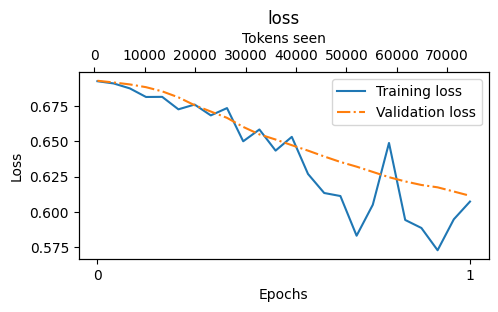

In [ ]:
from src.utils import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

- As we can see above, the loss continues to improve, which is a good sign
- Based on the downward slope, one might be tempted to train the model a bit further (and readers are encouraged to try this), but note that DPO is prone to collapse, where the model may start generating nonsensical responses
- Next, let's take a look at the reward margins:

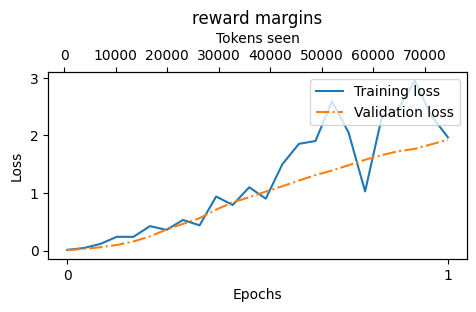

In [64]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)

- As we can see, and as it's desired, the reward margins improve; this mirrors the loss curve and is a good sign
- Note that DPO losses and reward margins are valuable metrics to track during training; however, they don't tell the whole story
- Lastly, and most importantly, we have to conduct a qualitative check of the responses
- Here, we will look at the response (in addition, you could use an LLM to score the responses similar to chapter 7)

In [65]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Reference model response:
>> The meal is cooked every day by the chef.

Policy model response:
>> The meal was prepared by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Reference model response:
>> Dance is a verb.

Policy model response:
>> The input string "Danced" could be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the 

- As we can see based on the reference model and policy model responses above, the optimized model (i.e., the policy model) indeed slightly changed its style compared to the original model (i.e., reference model)
- For instance, `"Dance" can be classified as a verb.` changed to `The input string "Dance" could be classified as a verb.` which is a slightly more polite response (the use of "could" instead of "can" makes the statement sound less assertive and more tentative)

In [66]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a cheetah.

Policy model response:
>> The car would be very fast.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Policy model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.

-------------------------------------

Below is an instruction that describes a task. Write a response that ap